### Pipeline for analyzing a single mock dataset
This was used to experiment before writing the scripts. Scripts are based on this notebook. It is setup that you just need to change the parameters in the 2nd block (in all caps eg. `WD` and `NUM_CORES`) and it will run

In [3]:
from qiime2 import Artifact
from qiime2 import Metadata
from qiime2.plugins.demux.methods import emp_single
from qiime2.plugins.quality_filter.methods import q_score
from qiime2.plugins.deblur.methods import denoise_16S
from skbio.diversity import beta_diversity
import pandas as pd
import wget
import biom
import os
import scipy

"""
This module holds methods used to test deblur post-trim vs pre-trim results
"""
def download_mock_dataset(working_dir_fp, sequences_url, barcodes_url,
                          metadata_url):
    """
    Downloads all the files we need from a mock dataset setup so qiime2 can
    work with them. Puts all files inside
    working_dir_fp + "/emp-single-end-sequences"

    :param working_dir_fp: filepath where sequences_url + barcodes_url file are downloaded to
                           and put into a directory "emp-single-end-sequences". Ideally, this should be a
                           mock-<n> directory from when you clone the mockrobiota github repo
                           should not end with "/"
    :param sequences_url: URL from which sequences are downloaded from using wget
    :param barcodes_url: URL from which barcodes are downloaded from using wget
    :param metadata_url: URL from which we get sample-metadata.tsv file
    """
    # setup files so qiime can work with them
    output_dir = working_dir_fp + "/emp-single-end-sequences"
    try:
        os.mkdir(output_dir)
    except FileExistsError:
       pass

    print("Downloading " + sequences_url)
    wget.download(sequences_url, output_dir + "/sequences.fastq.gz")
    print("Downloading " + barcodes_url)
    wget.download(barcodes_url, output_dir + "/barcodes.fastq.gz")
    print("Downloading " + metadata_url)
    wget.download(metadata_url, working_dir_fp)


def import_mock_dataset(working_dir_fp, metadata_barcode_column, rev_comp_barcodes_in=False,
                        rev_comp_mapping_barcodes_in=False):
    """
    Imports seqs as qiime artifact, demuxes them.
    Requires that fastq.gz files already be in
    working_dir_fp/emp-single-end-seqs and sample-metadata.tsv be in
    working_dir_fp

    :param working_dir_fp: filepath where sequences_url + barcodes_url file are downloaded to
                           and put into a directory "emp-single-end-sequences".
                           Should also contain sample-metadata.tsv.
                           Ideally, this should be a
                           mock-<n> directory from when you clone the mockrobiota github repo
                           should not end with "/"
    :param metadata_barcode_column: column header in sample-metadata.tsv that holds barcode data
    :param rev_comp_barcodes_i: param to emp_single for reversing barcode seqs
    :param rev_comp_mapping_barcodes_i: param to emp_single for reversing barcode seqs in metadata

    :return tuple of demuxed seqs, loaded metadata, None if fails
    """

    # TODO different if we are doing paired reads
    print("Importing seq data")
    seqs = Artifact.import_data("EMPSingleEndSequences", working_dir_fp +
                                "/emp-single-end-sequences")

    print("Loading metadata")
    barcode_metadata = Metadata.load(working_dir_fp + "/sample-metadata.tsv")

    print("Demuxing")
    demux, = emp_single(seqs,
                        barcode_metadata.get_category(metadata_barcode_column),
                        rev_comp_barcodes = rev_comp_barcodes_in,
                        rev_comp_mapping_barcodes = rev_comp_mapping_barcodes_in)
    return demux, barcode_metadata


def establish_dataset(demuxed_seqs, pre_trim_length, num_cores = 1):
    """
    Given demuxed sequences, quality filter, deblurs them and returns the result

    :param demuxed_data: qiime artifact of demuxed data
    :param pre_trim_length: length that we want to trim sequences to before
        deblur is ran

    :return FeatureTable[Frequency] of deblured data. Post-trimmed to length
    post_trim_length if post_trim_length is not None
    """
    print("Quality filtering (with default params)")
    demuxed_qfiltered, demuxed_qf_stats = q_score(demuxed_seqs)

    print("Deblur-ing with trim length {:d}".format(pre_trim_length))
    deblurred, repseq, deblur_stats = \
        denoise_16S(demuxed_qfiltered, pre_trim_length,
                    hashed_feature_ids = False, jobs_to_start = num_cores)

    return deblurred

def get_dl_urls(dataset_metadata_url, working_dir_fp):
    """
    :param dataset_metadata_url is url where we can download dataset metadata like this
    https://github.com/caporaso-lab/mockrobiota/blob/master/data/mock-6/dataset-metadata.tsv
    :param working_dir_fp: filepath where sequences_url + barcodes_url file are downloaded to
                           and put into a directory "emp-single-end-sequences".
                           Should not end with "/"
    :return tuple of 2 strings, URLs of sequence and index files respectively
    """
    wget.download(dataset_metadata_url, working_dir_fp)
    metadata_fp = working_dir_fp  + "/" + os.path.basename(dataset_metadata_url)
    metadata = pd.read_table(metadata_fp, index_col = 0, dtype=str)

    seq_url = metadata.loc["raw-data-url-forward-read", "value"]
    barcode_url = metadata.loc["raw-data-url-index-read", "value"]

    return seq_url, barcode_url


def post_trim(deblurred_biom, post_trim_length):
    """
    Trims a deblurred set of seqs-- utility fn so we dont have to re-run establish_dataset()
    :param deblurred_biom deblurred seqs as biom table
    :param post_trim_length length to trim to
    :return trimmed deblurred seqs as BIOM
    """
    print("Trimming post-demuxed seqs to {:d}".format(post_trim_length))
    post_trimmed_biom = \
        deblurred_biom.collapse(lambda i, m: i[:post_trim_length],
                                axis="observation", norm=False)

    #post_trimmed = Artifact.import_data("FeatureTable[Frequency]",
    #                                    post_trimmed_biom);
    return post_trimmed_biom

def get_distance_distribution(pre_table_overlap, post_table_overlap):
    """
    Given biom tables of overlapping reads, returns jaccard and bray curtis 
    distances between matching reads. 
    Two params should have exact same reads
    :param pre_table_overlap biom table for pre trimmed reads
    :param post_table_overlap biom table for post trimmed reads
    :return pandas dataframe with columns ["seq","dist_type","dist"]
    that hold sequence, type of distance and distance value
    """
    distance_functions = [('jaccard', scipy.spatial.distance.jaccard), ('braycurtis', scipy.spatial.distance.braycurtis)]

    results = []
    pre_pa = pre_table_overlap.pa(inplace=False)
    post_pa = post_table_overlap.pa(inplace=False)
    for obs in pre_table_overlap.ids(axis='observation'):
        for fname, f in distance_functions:
            if(fname == "jaccard"):
                a = pre_pa.data(obs, axis='observation', dense=True)
                b = post_pa.data(obs, axis='observation', dense=True)
            else:    
                a = pre_table_overlap.data(obs, axis='observation', dense=True)
                b = post_table_overlap.data(obs, axis='observation', dense=True)
            results.append((obs, fname, f(a, b))) # TODO maybe append sample too?

    results = pd.DataFrame(results, columns = ["seq", "dist_type", "dist"])
    return results

def get_pairwise_dist_mat(deblur_biom, dist_type):
    if(dist_type == "jaccard"):
        deblur_biom = deblur_biom.pa(inplace=False)
    
    dist_mat = beta_diversity(dist_type, 
                              deblur_biom.transpose().to_dataframe().as_matrix().astype("int64"),
                              ids = deblur_biom.ids(axis="sample"))
    return dist_mat


def get_overlap_tables(pre, post):
    """
    Takes in biom tables and returns the part of them that overlap in
    same order
    
    :param pre biom table of pre-trimmed deblurred seqs
    :param post biom table of post-trimmed deblurred seqs
    :return tuple of biom tables (pre_o,post_o) where each table only holds
            reads found in pre and post arguments
    """
    pre_ids = pre.ids(axis='observation')
    post_ids = post.ids(axis='observation')

    features_in_common = set(pre_ids) & set(post_ids)
    print(str(len(features_in_common)) + " reads in common when intersecting")
    pre_table_overlap = pre.filter(features_in_common, axis='observation', inplace=False)
    post_table_overlap = post.filter(features_in_common, axis='observation', inplace=False)

    # put the tables into the same order on both axes
    try:
        pre_table_overlap = pre_table_overlap.sort_order(post_table_overlap.ids(axis='observation'), axis='observation')
    except Error:
        print("Failed to sort tables, possibly because number of samples changed between pre and post")
        return

    return (pre_table_overlap, post_table_overlap)

def get_shortest_seq(demuxed):
    """
    Given a qiime artifact of demuxed reads, returns the length of the read
    :param qiime2 artifact of demuxed reads
    :return length of shortest read
    """
    directory = demuxed.view(SingleLanePerSampleSingleEndFastqDirFmt)

    lengths = {}
    for file_name, format_fp in directory.sequences.iter_views(FastqGzFormat):
        seqs = skbio.io.read(str(format_fp), format='fastq', phred_offset=33)
        lengths[str(format_fp)] = min(len(s) for s in seqs)

    return min(lengths.items())[1]

In [4]:
# PARAMS
# WD that holds "sample-metadata.tsv", and 
# a folder "emp-single-end-sequences" with files
# barcodes.fastq.gz and sequences.fastq.gz
WD = "test/analysis_testing_wd/mock-3"


LOAD_PRE_TRIMS = True
LOAD_DEMUX = True

# Whether to reverse barcodes, mapping barcodes, check README of mock page
REV_BC = False
REV_MAP_BC = True

# Dataset specific values for convinience
M7_TRIM_LENGHTS = [100,90,80,70,60]
M3_TRIM_LENGHTS = [150,120,100,90,80,70]

# Should be in descending order!!!!
# We will use first element for post-trims
NUM_CORES = 4
TRIM_LENGTHS = M3_TRIM_LENGHTS

In [5]:
if(LOAD_DEMUX):
    barcode_metadata = Metadata.load(WD + "/sample-metadata.tsv")
    demuxed = Artifact.load(WD + "/demux.qza")
else:
    demuxed, barcode_metadata = import_mock_dataset(WD, "BarcodeSequence", 
                                                    rev_comp_barcodes_in=REV_BC,
                                                    rev_comp_mapping_barcodes_in=REV_MAP_BC)
    demuxed.save(WD + "/demux")

In [6]:
pre_trims = []
if(LOAD_PRE_TRIMS):
    for length in TRIM_LENGTHS:
        deblurred = Artifact.load(WD + "/deblurred_pre_" + str(length) + "nt.qza")
        pre_trims.append(deblurred)
else:
    for length in TRIM_LENGTHS:
        deblurred = establish_dataset(demuxed, pre_trim_length=length, num_cores=NUM_CORES)
        pre_trims.append(deblurred)
        deblurred.save(WD + "/deblurred_pre_" + str(length) + "nt")

pre_trims

[<artifact: FeatureTable[Frequency] uuid: 6703259b-f165-4022-b291-7ed37f6e2153>,
 <artifact: FeatureTable[Frequency] uuid: f96d1678-9397-429f-b5e7-ea09d23a6e65>,
 <artifact: FeatureTable[Frequency] uuid: 4fa2ed0f-2332-4b6a-83a3-e611a5a92eab>,
 <artifact: FeatureTable[Frequency] uuid: 255769e9-4ad0-441a-ae7d-845a50f08db5>,
 <artifact: FeatureTable[Frequency] uuid: 910e9f5b-5479-4aeb-bed1-2654117fdb49>,
 <artifact: FeatureTable[Frequency] uuid: 2bccb2bd-4251-46a7-9309-98af386cf90c>]

In [7]:
post_trims = []
for i in range(len(TRIM_LENGTHS)):
    trimmed_biom = post_trim(pre_trims[0].view(biom.Table), TRIM_LENGTHS[i])
    trimmed = Artifact.import_data("FeatureTable[Frequency]", trimmed_biom);
    post_trims.append(trimmed)
    trimmed.save(WD + "/deblurred_pt_" + str(length) + "nt")

post_trims

Trimming post-demuxed seqs to 150
Trimming post-demuxed seqs to 120
Trimming post-demuxed seqs to 100
Trimming post-demuxed seqs to 90
Trimming post-demuxed seqs to 80
Trimming post-demuxed seqs to 70


[<artifact: FeatureTable[Frequency] uuid: 8900395c-9df4-4e9f-9838-a2b3a68b5bbf>,
 <artifact: FeatureTable[Frequency] uuid: 41368896-56db-4bf8-bee8-4d7f306cedb0>,
 <artifact: FeatureTable[Frequency] uuid: aeb7f37f-adea-47e5-b184-467346506100>,
 <artifact: FeatureTable[Frequency] uuid: 5f412669-48f9-4a12-8629-1c034e2eda26>,
 <artifact: FeatureTable[Frequency] uuid: d3e63308-56db-46df-b5c0-2b6e44a852e2>,
 <artifact: FeatureTable[Frequency] uuid: 5b596e0d-e4eb-48fc-93a1-543900006326>]

In [8]:
pre_pt_table = pd.DataFrame()
pre_pt_table["pre"] = pre_trims
pre_pt_table["post"] = post_trims
pre_pt_table["length"] = TRIM_LENGTHS

dists_overlaps = pd.DataFrame()
overlap_bioms = dict()
pre_overlaps = []
post_overlaps = []
for i in range(pre_pt_table.shape[0]):
    pre_overlap_biom, post_overlap_biom = \
        get_overlap_tables(pre_pt_table.iloc[i,0].view(biom.Table), 
                           pre_pt_table.iloc[i,1].view(biom.Table))
    pre_overlaps.append(pre_overlap_biom)    
    post_overlaps.append(post_overlap_biom)    
        
    dists = get_distance_distribution(pre_overlap_biom, post_overlap_biom)
    dists["length"] = pre_pt_table.iloc[i,2]
    dists_overlaps = dists_overlaps.append(dists)
    overlap_bioms[pre_pt_table.iloc[i,2]] = pre_overlap_biom # TODO look at this
    
pre_pt_table["pre_overlap"] = pre_overlaps
pre_pt_table["post_overlap"] = post_overlaps

14 reads in common when intersecting
14 reads in common when intersecting
13 reads in common when intersecting
13 reads in common when intersecting
13 reads in common when intersecting
14 reads in common when intersecting


Text(0.5,1,'Jaccard')

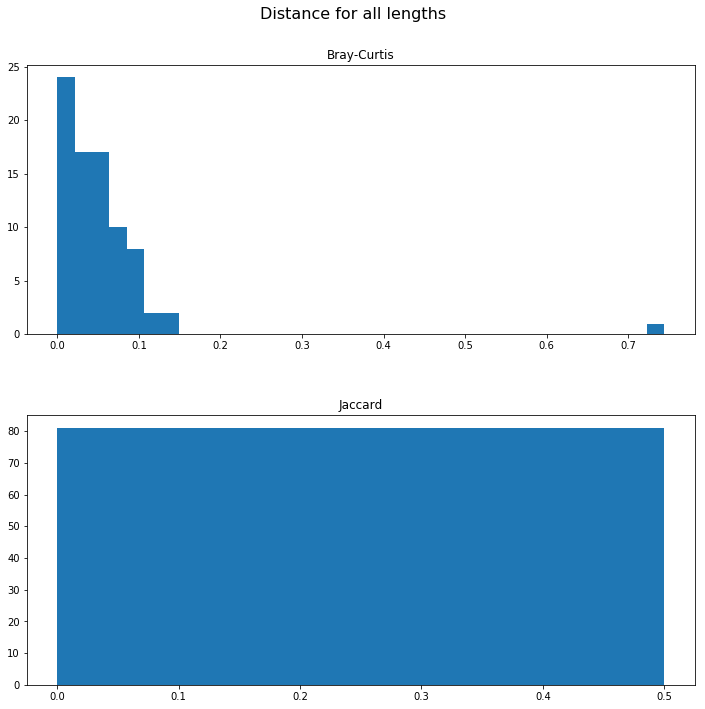

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
f, (ax1, ax2) = plt.subplots(2, 1 ,figsize=(10,10))
plt.tight_layout()
plt.suptitle("Distance for all lengths", size=16)
plt.subplots_adjust(top=0.9, hspace = 0.3)
ax1.hist(dists_overlaps[dists_overlaps["dist_type"] == "braycurtis"]["dist"], bins = 'auto')
ax1.set_title("Bray-Curtis")
ax2.hist(dists_overlaps[dists_overlaps["dist_type"] == "jaccard"]["dist"], bins = 'auto')
ax2.set_title("Jaccard")

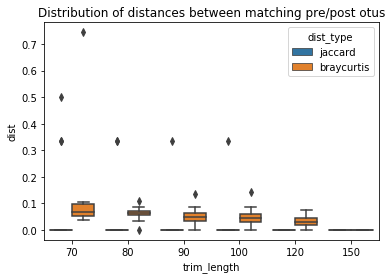

In [10]:
import seaborn as sns
ax = sns.boxplot(x="length", y="dist", data=dists_overlaps, hue="dist_type")
ax.set(xlabel="trim_length", title="Distribution of distances between matching pre/post otus")
ax.figure.savefig("aplot.png")

Text(0.5,0.98,'Distances for trim lengths')

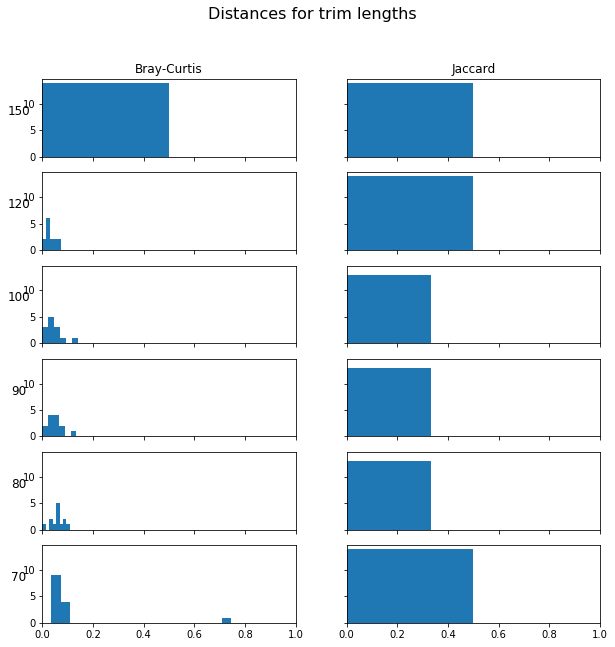

In [11]:
%matplotlib inline
fig, axes = plt.subplots(len(TRIM_LENGTHS), 2, sharey = True, sharex = True, figsize = (10,10))

for i in range(len(TRIM_LENGTHS)):
    axes[i,0].hist(dists_overlaps[(dists_overlaps["dist_type"] == "braycurtis") & \
                                  (dists_overlaps["length"] == TRIM_LENGTHS[i])]["dist"], bins = 'auto')
    axes[i,1].hist(dists_overlaps[(dists_overlaps["dist_type"] == "jaccard") & \
                                  (dists_overlaps["length"] == TRIM_LENGTHS[i])]["dist"], bins = 'auto')

axes[0,0].set_title("Bray-Curtis")
axes[0,1].set_title("Jaccard")
axes[0,0].set_xlim([0,1])

for ax, row in zip(axes[:,0], TRIM_LENGTHS):
    ax.set_ylabel(str(row), rotation=0, size='large')

plt.suptitle("Distances for trim lengths", size=16)

In [12]:
%%capture
import numpy as np
def num_sOTUs(biom_table):
    return biom_table.length(axis="observation")

# total number of unique sOTUs between a pre/post trim table
sOTU_nums = [[x, num_sOTUs(overlap_bioms[x])] for x in TRIM_LENGTHS]

# total number of sOTUs that are unique to pre and unique post
num_uniq = np.empty([len(TRIM_LENGTHS),2])
pre_post_bioms = np.empty([len(TRIM_LENGTHS),2], dtype=object)
for i in range(0,pre_pt_table.iloc[:,0:2].shape[0]): 
    for j in range(0,pre_pt_table.iloc[:,0:2].shape[1]):
        pre_post_bioms[i,j] = pre_pt_table.iloc[i,j].view(biom.Table)
        print("{:d},{:d}".format(i,j))
        print("len: {:d}".format(len(pre_post_bioms[i,j].ids(axis="observation")[0])))
        #print(pre_post_bioms[i,j].ids(axis="observation"))
        print("num_sOTUs(pre_post_bioms[i,j]) {:d}".format(num_sOTUs(pre_post_bioms[i,j]), sOTU_nums[i][1]))
        num_uniq[i,j] = num_sOTUs(pre_post_bioms[i,j]) - sOTU_nums[i][1]

# total number of samples in pre and post (really hope that doesn't fluctuate)
def num_samples(biom_table):
    return biom_table.length(axis="sample")

v_num_samples = np.vectorize(num_samples)
m_num_samples = v_num_samples(pre_post_bioms)

# total read counts per sample
def total_read_counts(biom_table):
    return biom_table.sum(axis="sample")

sample_read_count_deltas = np.empty([len(TRIM_LENGTHS),m_num_samples[0,0]]) # 4 is num samples
for i in range(pre_post_bioms.shape[0]):
    #sample_read_count_deltas[i] = total_read_counts(pre_post_bioms[i,1]) - \
    #                                total_read_counts(pre_post_bioms[i,0])
    sample_read_count_deltas[i] = total_read_counts(pre_post_bioms[i,0]) - \
                                    total_read_counts(pre_post_bioms[i,1])
        
def s_total_read_counts(biom_table):
    return str(biom_table.sum(axis="sample"))
v_total_read_counts = np.vectorize(s_total_read_counts)
m_total_reads_per_sample = v_total_read_counts(pre_post_bioms)

In [13]:
# Put everything in a pandas dataframe so it is easier
sOTU_data = pd.DataFrame()
sOTU_nums = np.array(sOTU_nums)
sOTU_data["read_length"] = sOTU_nums[:,0]
sOTU_data["overlap_count"] = sOTU_nums[:,1]
sOTU_data["unique_pre"] = num_uniq[:,0] 
sOTU_data["unique_post"] = num_uniq[:,1] 

sample_data = pd.DataFrame()
sample_data["read_length"] = sOTU_nums[:,0]
sample_data["num_samples_pre"] = m_num_samples[:,0]
sample_data["num_samples_post"] = m_num_samples[:,1]
#sample_data["change_num_samples"] = sample_data["num_samples_post"] - sample_data["num_samples_pre"]
sample_data["change_num_samples"] = sample_data["num_samples_pre"] - sample_data["num_samples_post"]

df_sample_delta = pd.DataFrame(sample_read_count_deltas, columns = pre_post_bioms[0,0].ids(axis="sample"))
df_sample_delta.index = sOTU_nums[:,0]

Text(0.5,0,'Trim Length')

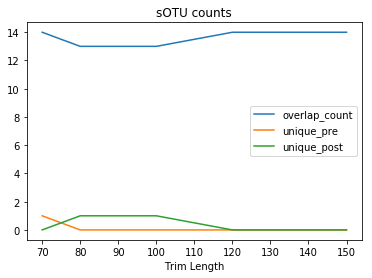

In [14]:
%matplotlib inline
plt.plot(sOTU_data["read_length"], sOTU_data["overlap_count"])
plt.plot(sOTU_data["read_length"], sOTU_data["unique_pre"])
plt.plot(sOTU_data["read_length"], sOTU_data["unique_post"])

plt.legend(sOTU_data.columns[1:], loc='best')
plt.title("sOTU counts")
plt.xlabel("Trim Length")

In [15]:
sample_data

,read_length,num_samples_pre,num_samples_post,change_num_samples
0,150,4,4,0
1,120,4,4,0
2,100,4,4,0
3,90,4,4,0
4,80,4,4,0
5,70,4,4,0


Text(0.5,0,'Trim Length')

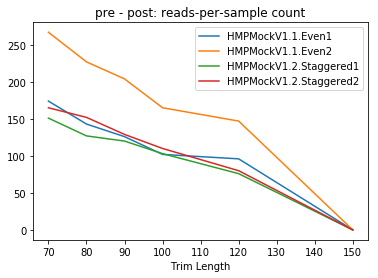

In [16]:
%matplotlib inline
for colname in df_sample_delta.columns:
    plt.plot(df_sample_delta.index, df_sample_delta[colname])

plt.legend(df_sample_delta.columns, loc='best')
plt.title("pre - post: reads-per-sample count")
plt.xlabel("Trim Length")

In [17]:
m_total_reads_per_sample

array([['[ 1513.  2807.  1047.  1267.]', '[ 1513.  2807.  1047.  1267.]'],
       ['[ 1609.  2954.  1123.  1347.]', '[ 1513.  2807.  1047.  1267.]'],
       ['[ 1615.  2972.  1150.  1377.]', '[ 1513.  2807.  1047.  1267.]'],
       ['[ 1639.  3011.  1167.  1396.]', '[ 1513.  2807.  1047.  1267.]'],
       ['[ 1656.  3034.  1174.  1419.]', '[ 1513.  2807.  1047.  1267.]'],
       ['[ 1687.  3074.  1198.  1432.]', '[ 1513.  2807.  1047.  1267.]']], 
      dtype='<U29')

In [18]:
from skbio.stats.distance import mantel

# Get pairwise distances between each sample
cols = ["trim_length", "dist_type", "r", "pval", "nsamples"]
pairwise_diversity = pd.DataFrame(columns=cols)
for i in range(pre_pt_table.shape[0]):
    pre = pre_pt_table.iloc[i,0]
    post = pre_pt_table.iloc[i,1]
    
    pre_biom = pre_post_bioms[i,0]
    post_biom = pre_post_bioms[i,1]
    
    pre_d_j = get_pairwise_dist_mat(pre_biom, "jaccard")
    post_d_j = get_pairwise_dist_mat(post_biom, "jaccard")
    r, p, nsamp = mantel(pre_d_j, post_d_j)
    trim_length = TRIM_LENGTHS[i]
    pairwise_diversity = pairwise_diversity.append(dict(zip(cols, [trim_length, "jaccard", r, p, nsamp])),
                                                   ignore_index=True) 
    
    pre_d_bc = get_pairwise_dist_mat(pre_biom, "braycurtis")
    post_d_bc = get_pairwise_dist_mat(post_biom, "braycurtis")
    r, p, nsamp = mantel(pre_d_bc, post_d_bc)
    pairwise_diversity = pairwise_diversity.append(dict(zip(cols, [trim_length, "braycurtis", r, p, nsamp])),
                                                   ignore_index=True) 
    
pairwise_diversity["r_sq"] = pairwise_diversity["r"]**2
pairwise_diversity

,trim_length,dist_type,r,pval,nsamples,r_sq
0,150,jaccard,1.000000,0.034,4,1.000000
1,150,braycurtis,1.000000,0.046,4,1.000000
2,120,jaccard,1.000000,0.038,4,1.000000
3,120,braycurtis,0.999954,0.038,4,0.999907
4,100,jaccard,0.925795,0.049,4,0.857096
5,100,braycurtis,0.999746,0.046,4,0.999493
6,90,jaccard,0.925795,0.043,4,0.857096
7,90,braycurtis,0.999839,0.039,4,0.999679
8,80,jaccard,0.895709,0.080,4,0.802294
9,80,braycurtis,0.999509,0.038,4,0.999019


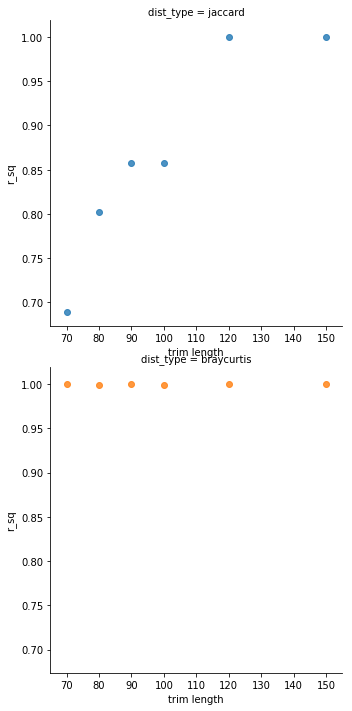

In [19]:
import seaborn as sns
ax = sns.lmplot(x="trim_length", y="r_sq", row="dist_type", hue="dist_type",
           data=pairwise_diversity, ci=None, fit_reg=False)
ax.set(xlabel="trim length")

In [20]:
# For each length, do mantel test between the two freq tables
# First, make the tables only have

[Text(0.5,0,'trim_length'),
 Text(0.5,1,'Distribution of distances between matching pre/post otus')]

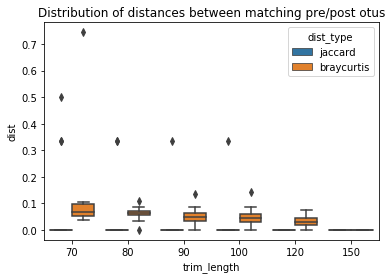

In [21]:
ax = sns.boxplot(x="length", y="dist", data=dists_overlaps, hue="dist_type")
ax.set(xlabel="trim_length", title="Distribution of distances between matching pre/post otus")

In [22]:
# Normalize accross samples and see what happens
pairwise_diversity

,trim_length,dist_type,r,pval,nsamples,r_sq
0,150,jaccard,1.000000,0.034,4,1.000000
1,150,braycurtis,1.000000,0.046,4,1.000000
2,120,jaccard,1.000000,0.038,4,1.000000
3,120,braycurtis,0.999954,0.038,4,0.999907
4,100,jaccard,0.925795,0.049,4,0.857096
5,100,braycurtis,0.999746,0.046,4,0.999493
6,90,jaccard,0.925795,0.043,4,0.857096
7,90,braycurtis,0.999839,0.039,4,0.999679
8,80,jaccard,0.895709,0.080,4,0.802294
9,80,braycurtis,0.999509,0.038,4,0.999019


In [23]:
dists_overlaps

,seq,dist_type,dist,length
0,TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...,jaccard,0.000000,150
1,TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...,braycurtis,0.000000,150
2,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCG...,jaccard,0.000000,150
3,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCG...,braycurtis,0.000000,150
4,TACCGAGGGTGCGAGCGTTAATCGGATTTACTGGGCGTAAAGCGTG...,jaccard,0.000000,150
5,TACCGAGGGTGCGAGCGTTAATCGGATTTACTGGGCGTAAAGCGTG...,braycurtis,0.000000,150
6,TACGTAGGGCGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCT...,jaccard,0.000000,150
7,TACGTAGGGCGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCT...,braycurtis,0.000000,150
8,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCA...,jaccard,0.000000,150
9,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCA...,braycurtis,0.000000,150


# Dan meeting notes
- Do distances beteen features.eg. feature/otu A is in pre and post make df of cols = featureA featureB, trim length, dist_type, 0.1 plot distribution of distances this is NOT pairwise want to see trim length ! effect distribution

- new plot
    x-axis pre trim
    y-axis post trim
    plot r^2 values NAWWW lol

- IDEAS ON HOW TO VISUALIZE?
    - compare pre and post trims of same length

- transition to repo, outside of notebooks decouple compute and visualization 
- dan on road next week

# Plan to code-ify pipeline

Goal: Determine whether deblurring and trimming after the fact is different than re-deblurring to post trim length.

## Plan
### Requirements
- Easily ran on datasets
- Can aggregate the data of all the runs
- Modular so if one section fails, do not need to re-run everything


### How do we aggregate data? / Aggregate metrics
- Issue, trim lengths are depending on dataset!
- Solution: Have two pools, 150nt, 100nt (fair amount of coding)
- Do trim lengths as percentage of original length
    - 60, 70, 80, 90, 100%
    - pre - post, sotu count plots need to change to percent change rather than counts
    

### Inputs
- input folder, path to folder that holds the fo
    - seqs: file called "sequnces.fastq.gz"
    - barcodes: file called "barcodes.fastq.gz"
- trim length increment: default 10
- num of trim lengths: default 5 ** INCLUDES 100% **
- num cores: default 1
- rev_map_bc: true or false, default false
- rev_bc: true or false, default false
- output-dir: default same level as input dir
- max trim length: OPTIONAL

### Outputs
- Demuxed qza
- Deblurred qza, Deblurred_pt qza
- tsv's that we can easily plot, in subdir called "data" (make into 1 tsv if possible)
- pdf of plots


### Phases
1. Demux
2. Deblur pre trim all lengths
3. Post trimming
4. Analysis
5. Plotting
6. Aggregate plots

## Implementation
One script per phase, lots of output so we know which phase failed
1-5 Should be grouped together in a master script. Maybe make a script that combines 1-5 and 6 so we can run on many datasets and then aggregate.

### Phase 1: Demux
#### Inputs
- input folder, path to folder that holds the fo
    - seqs: file called "sequnces.fastq.gz"
    - barcodes: file called "barcodes.fastq.gz"
- rev_map_bc: true or false, default false
- rev_bc: true or false, default false
- output-dir: default same level as input dir

#### Outputs
- Demuxed seqs as qza OR python artifact

#### Psuedocode

```
Demux the sequences
Save the qza to output-dir
```

### Phase 2: Deblur
#### Inputs
- input: path to demuxed qza OR python artifact 
    - Do type enforcement!
- trim length increment: default 10
- num of trim lengths: default 5 ** INCLUDES 100% **
- output-dir: default same level as input dir
- max trim length: OPTIONAL b/c calculating it could significantly increase runtime

#### Outputs
- deblurred seqs for various lengths as qza and/or artifacts

#### Pseudocode

```
if(using a qza)
    load the qza to python artifact
    
if(max trim length not provided)
    find it out using demuxed

calculate trim lengths, save to list L

for each trim length in L
   quality filter the python artifact
   deblur it using pre trim length L
   save qza of deblurred for output dir
```

### Phase 3: Post-trim
#### Inputs
- input: path to deblurred qza OR python artifact
    - Do type enforcement!
    - should be max length
- trim length increment: default 10
- num of trim lengths: default 5 ** INCLUDES 100% **
- max trim length: OPTIONAL not a big deal because it can be easily inferred
- output-dir: default same level as input dir

#### Outputs
- deblurred seqs for various lengths as qza and/or artifacts

#### Pseudocode

```
if(using a qza)
    load the deblurred.qza to python artifact // max length pre-trim
    
if(max trim length not provided)
    find it out. It is the length of any seq in the deblurred qza

calculate trim lengths, save to list L

for each trim length in L
   post-trim the artifact
   save qza of deblurred for output dir
```

### Phase 4: Analysis
#### Inputs
- all pre-trim and post-trim qzas OR python artifacts
- output dir

#### Outputs
- tsv disances between pre, post otus
- tsv for sOTU counts and pre - post, include percentages col
- tsv for mantel test
- all exported to output_dir/data

#### Pseudocode

```
if(using qzas)
    load all of them to python artifacts

# Distance pre to post plots
# Histograms of BC + Jaccard
# Box plots of distributions by trim length
# Histograms for each trim length
Make single pandas dataframe
export it to csv

# sOTU counts by trim length
# Pre - post reads per sample counts
Do as percentages, put in pandas dataframe
export as tsv


# Pairwise distance Mantel test 
# R squared vs. trim length
Export a csv
```

### Phase 5: Plotting
#### Inputs
- paths to (ideally all in one dir): 
    - tsv disances between pre, post otus
    - tsv for sOTU counts and pre - post, include percentages col
    - tsv for mantel test
    
#### Outputs
- pdf with all the plots

### Phase 6: Aggregate
#### Inputs 
- Many of these:
    - tsv disances between pre, post otus
    - tsv for sOTU counts and pre - post, include percentages col
    - tsv for mantel test
    
#### Outputs
- Concatenated tsv's in output dir
- Plots

In [24]:
demuxed

<artifact: SampleData[PairedEndSequencesWithQuality] uuid: f3b944ff-18fa-4301-8108-63cc7a27ca31>

In [25]:
import numpy as np
foo = biom.Table(np.array([[1,1,0],[0,2,3]]),
              ['A', 'B'], ['S1', 'S2','S3'])
dmat = get_pairwise_dist_mat(foo,"braycurtis")

In [26]:
dmat.data

array([[ 0.        ,  0.5       ,  1.        ],
       [ 0.5       ,  0.        ,  0.33333333],
       [ 1.        ,  0.33333333,  0.        ]])

In [27]:
len(pre_post_bioms[0][0].ids(axis="observation")[0])

150

In [28]:
pre_sums = [total_read_counts(table) for table in pre_post_bioms[:,0]]

In [29]:
foo = pd.DataFrame(pre_sums, columns = pre_post_bioms[0,0].ids(axis="sample"))

In [30]:
df_sample_delta

,HMPMockV1.1.Even1,HMPMockV1.1.Even2,HMPMockV1.2.Staggered1,HMPMockV1.2.Staggered2
150,0.0,0.0,0.0,0.0
120,96.0,147.0,76.0,80.0
100,102.0,165.0,103.0,110.0
90,126.0,204.0,120.0,129.0
80,143.0,227.0,127.0,152.0
70,174.0,267.0,151.0,165.0


In [31]:
read_changes = pd.read_csv("/Users/massoudmaher/Documents/Code/deblur-testing/test/analysis_testing_wd/mock-3-demo/read_changes.csv")

FileNotFoundError: File b'/Users/massoudmaher/Documents/Code/deblur-testing/test/analysis_testing_wd/mock-3-demo/read_changes.csv' does not exist

In [ ]:
read_changes.columns[1:]

In [ ]:
pre_post_bioms[0][0].to_dataframe()

In [ ]:
from scipy.spatial.distance import pdist
pdist([[2,1],[0,2]], "braycurtis")